# [GLOBAL 150Q/PACS 190] Data Analysis (2)

### Professor Crystal Chang Cohen, Professor Tiffany Page 

In this notebook, we will learn how to analyze survey data. We will use cleaned data from the last notebook to manipulate data tables, create data visualizations, and interpret results. 

--------------------------------------------------------------------------------------------------------------------------------

### Topics Covered
 - Pivot Tables
 - Bar Charts 
 - Statistical Significance 
 - Correlation vs. Causation
 - Bias in Survey Data

### Table of Contents

##### Dependencies:

In [1]:
from datascience import *
from utils import *
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np
%matplotlib inline

### The Data

You'll be working with data collected from a survey about the voting patterns of students at UC Berkeley. This data was collected by Hannah Hill, who used the data to study the factors that influence youth voter turnout. In this notebook, we will analyze the cleaned data from the last notebook and interpret the results. Here's a peek at the first few rows of our dataset:

In [2]:
data = Table().read_table('cleaned_data.csv')
data.show(3)

C:\Anaconda3\lib\site-packages\datascience\tables.py:132: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pandas.read_table(filepath_or_buffer, *args, **vargs)


Q5,Q7,Q8,Q9,Q15,Q16,Q17,Q20,Q23,Q23_5_TEXT,Q29_1,Q31,Q55,Q35,Q36,Q40_1,Q40_2,Q40_3,Q41_23,Q42_1,Q42_2,Q42_3,Q43_1,Q43_2,Q43_3,Q43_4,Q43_5,Q43_6,Q43_7,Q43_8,Q43_9,Q43_10,Q43_11,Q43_11_TEXT,Q44_0_GROUP,Q44_0_1_RANK,Q44_0_15_RANK,Q44_0_4_RANK,Q44_0_5_RANK,Q44_0_6_RANK,Q44_0_9_RANK,Q44_0_10_RANK,Q44_0_11_RANK,Q44_0_12_RANK,Q44_0_13_RANK,Q44_0_14_RANK,Q44_0_16_RANK,Q44_0_8_RANK,Q44_8_TEXT,Q47_1,Q47_2
Social Sciences,Woman,White,21,Yes,Polling station,Trump,Happy,Volunteering,nan,nan,No; I did not check,Mostly Republicans,Yes,No,1,1,1,7,2,6,6,5,5,5,5,5,5,5,5,5,5,0,nan,"Fox News,New York Times,CBS,Twitter,CNN",nan,4,2,5,1,nan,3,nan,nan,nan,nan,nan,nan,nan,Moderately knowledgeable,Slightly knowledgeable
Engineering/Computer Science,Man,White,20,Yes,Polling station,Trump,nan,Volunteering,nan,3,No; I do not know how,Mostly Republicans,No,No,4,2,2,7,3,4,1,5,4,4,4,3,3,4,3,3,3,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Slightly knowledgeable,Very knowledgeable
Social Sciences,Woman,Mixed Race,18,nan,nan,nan,"Sad,Scared,Angry",Community engagement,nan,nan,Yes; it was counted,Only Democrats,Yes,No,5,5,4,2,6,6,3,5,5,5,4,4,5,5,4,4,4,0,nan,"CNN,New York Times,Twitter,Facebook,Washington Post",4,3,2,1,nan,5,nan,nan,nan,nan,nan,nan,nan,nan,Extremely knowledgeable,Extremely knowledgeable


Let's start by looking at the relationships between Major, Gender Identity, and Ethnicity and candidate of choice in the 2016 Presidential Election.

### Part I: Relationship between Demographic Factors and Presidential Choice

#### Exercise 1.1: Displaying Rows

Let's get an idea of the data we're working with. 

**TASK:** Use the **.select** function to display only the columns pertaining to Major and Presidential Candidate vote. 

Remember that you can use Python's lists ([x, y]) to select more than one column at once. Save this new table into a name called **major_presidential_vote**. 

In [3]:
major_presidential_vote = data.select(['Q5', 'Q17'])
major_presidential_vote

Q5,Q17
Social Sciences,Trump
Engineering/Computer Science,Trump
Social Sciences,nan
Life Sciences,Clinton
Arts & Humanities,nan
Arts & Humanities,Clinton
Social Sciences,Clinton
Arts & Humanities,3rd party
Engineering/Computer Science,nan
Arts & Humanities,Clinton


#### Exercise 1.2: Filtering Rows

**Question:** What observations do you have about the structure or values in this table?

**Answer:** [Click on this cell and write your answer here]

Those *'nan's* represent missing values. They usually arise when someone chooses not to respond to a question. It is also possible to get missing values if the data isn't formatted correctly. In any case, we will have to remove those values before proceeding. 


Let's take a look at the proportion of missing values in both columns of the table.

In [4]:
print("The proportion of missing values in the first column is: {}".format(missing_proportion(major_presidential_vote, 'Q5')))
print()
print("The proportion of missing values in the second column is: {}".format(missing_proportion(major_presidential_vote, 'Q17')))

The proportion of missing values in the first column is: 0.0

The proportion of missing values in the second column is: 0.54


That's a *lot* of missing values in the second column we must deal with before we can proceed. 

**TASK:** Use the **drop_missing_rows** function to return a table which doesn't contain any missing values. This function takes in a table and a column name to drop missing values from. Save the resulting table into a name called **cleaned_major_presidential_votes**.

*Hint:* Which column do we want to remove missing values from?

In [5]:
cleaned_major_presidential_votes = drop_missing_rows(major_presidential_vote, 'Q17')
cleaned_major_presidential_votes

Q5,Q17
Social Sciences,Trump
Engineering/Computer Science,Trump
Life Sciences,Clinton
Arts & Humanities,Clinton
Social Sciences,Clinton
Arts & Humanities,3rd party
Arts & Humanities,Clinton
Engineering/Computer Science,Clinton
Engineering/Computer Science,Clinton
Engineering/Computer Science,Clinton


Just to double check whether we removed all the missing values, let's print the proportion of missing values in the new table. 

In [6]:
print("The proportion of missing values in the first column is: {}".format(missing_proportion(cleaned_major_presidential_votes, 'Q5')))
print()
print("The prorportion of missing values in the second column is: {}".format(missing_proportion(cleaned_major_presidential_votes, 'Q17')))

The proportion of missing values in the first column is: 0.0

The prorportion of missing values in the second column is: 0.0


Great work! We're now ready to start processing our data into a more meaningful format.

#### Exercise 1.3: Pivot Tables

Pivot tables are data structures that allow us to summarize key points in our dataset. In our case, we are trying to look at the relationship between Major and Presidential Vote. Our *independent variable*, or the variable that we believe influences the other in this case, is Major. This variable should be presented along the columns of our pivot table. The *dependent variable* should be placed along the rows of the pivot table. The data within the table will be counts of unique pairings.

**TASK:** Use the Table method **.pivot** to create a pivot table between Major and Presidential Vote. This function takes in two arguments: the column name to be displayed along the columns, and the column name to be displayed along the rows. Save the resulting pivot table into a name called **pivoted_major_presidential_votes**.

In [7]:
pivoted_major_presidential_votes = cleaned_major_presidential_votes.pivot('Q5', 'Q17')
pivoted_major_presidential_votes

Q17,Arts & Humanities,Business,Engineering/Computer Science,Life Sciences,Physical Sciences/Mathematics,Social Sciences
3rd party,6,2,4,5,1,5
Clinton,34,7,41,44,14,68
Trump,2,1,2,0,0,3


Let's understand what's happening here. In the first column, we have the three possibilities for presidential votes. Along the rest of the columns, we have the possibilities for major choice. The values in the 2nd column onwards contain the counts of unique pairings between Major and Presidential Vote. For example, there were 34 people who *both* voted for Hillary Clinton and majored in Arts & Humanities.

**Question:** Is this pivot table enough information to make conclusions about Major and Presidential Choice? Why or why not? 

**Answer:** [Click on this cell and write your answer here]

We need to convert the counts in the pivot table to proportions to make a fair comparison between Majors.

**TASK:** Use the function **counts_to_proportions** to convert the pivot table into another pivot table with proportions. This function takes in a pivot table and returns a modified pivot table. Save the result into a name called **proportion_major_vote**.

In [8]:
proportion_major_vote = counts_to_proportions(pivoted_major_presidential_votes)
proportion_major_vote

Q17,Arts & Humanities,Business,Engineering/Computer Science,Life Sciences,Physical Sciences/Mathematics,Social Sciences
3rd party,0.142857,0.2,0.0851064,0.102041,0.0666667,0.0657895
Clinton,0.809524,0.7,0.87234,0.897959,0.933333,0.894737
Trump,0.047619,0.1,0.0425532,0,0,0.0394737


Awesome job! We're almost ready to start making inferences. The last step is to visualize our data. 

#### Exercise 1.4: Bar Charts

Our goal is to visualize the proportion of students who voted for each presidential candidate on a chart. We can use *bar charts* to do this. According to Wikipedia, a *bar chart* is a data visualization which "presents categorical data with rectangular bars with heights or lengths proportional to the values that they represent."

Before we delve into analysis, let's look at a simple application of bar charts: How are Majors distributed within our dataset?

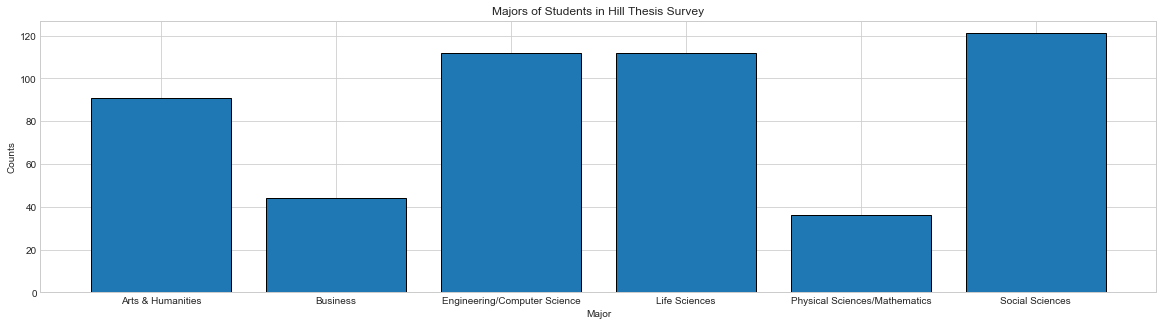

In [9]:
plt.figure(figsize = (20, 5))
plt.bar(data.group('Q5').column('Q5'), data.group('Q5').column('count')); # Run this cell
plt.xlabel('Major')
plt.ylabel('Counts')
plt.title('Majors of Students in Hill Thesis Survey'); 

**Question:** What does this bar chart tell us about the distribution of majors within our dataset? Do you think this dataset is representative of the total student population?

**Answer:** [Click on this cell and write your answer here]

**TASK:** Use the **plot_bar_chart** function to visualize the proportions of votes of Business Majors for each presidential candidate. This function takes in 4 arguments. First, enter the relevant pivot table. Next, enter a list containing the column name(s) you want to visualize. Additionally, enter a title for the chart. Finally, enter the variable of comparison.

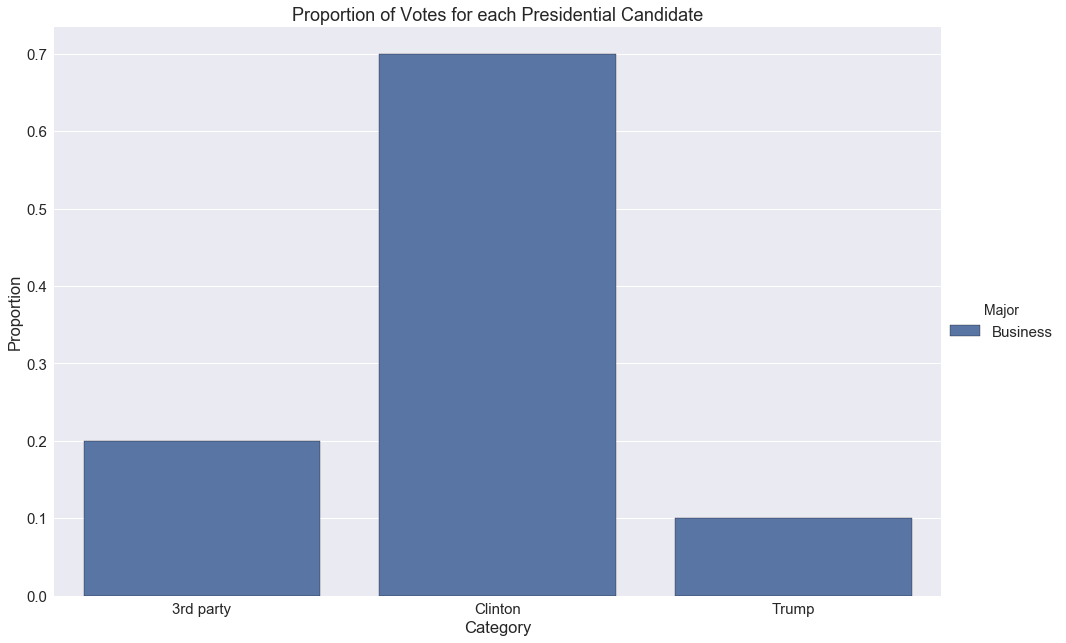

In [10]:
plot_bar_chart(proportion_major_vote, ['Business'], 'Proportion of Votes for each Presidential Candidate', 'Major')

**TASK:** Next, use the **plot_bar_chart** method to visualize the proportions of votes made among all majors. 

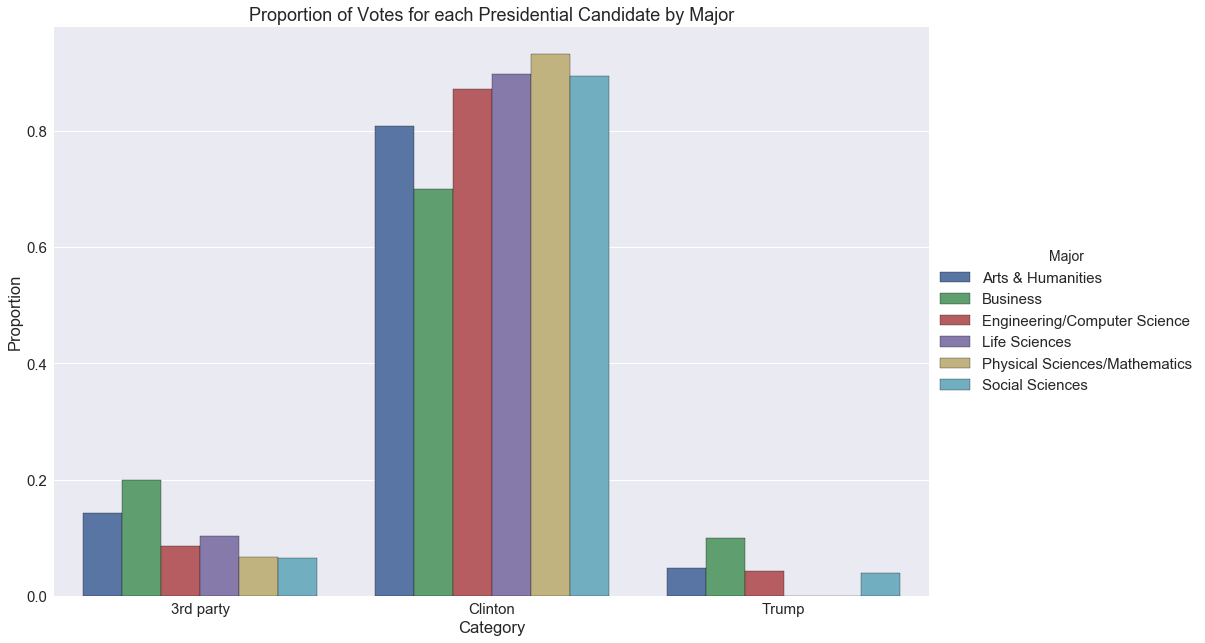

In [11]:
plot_bar_chart(proportion_major_vote, ['Arts & Humanities', 'Business', 'Engineering/Computer Science', 'Life Sciences',
                'Physical Sciences/Mathematics', 'Social Sciences'], 
               'Proportion of Votes for each Presidential Candidate by Major', 'Major')

**Question:** What majors tend to have similar voting patterns? Are there any differences that stand out? Why do you think this may be the case?

**Answer:** [Click on this cell and write your answer here]

### Recap

We've covered quite a bit so far. Let's summarize what we've covered so far:

1. Filtering Rows for Missing Values and Improper Formatting


2. Re-structuring the dataset into Pivot Tables


3. Creating Bar Charts to visualize the relationship between categorical variables


4. Interpreting visualizations

#### Exercise 1.5: Processing Pipeline

In data science, when you repeat a set of tasks to analyze a dataset, you are creating a *data processing pipeline*. 

We've now analyzed the relationship between a student's major and their choice of Presidential candidate. Let's extend our analysis to Gender Identity and Ethnicity as well. 

**TASK:** Write a function that takes in a table, two column names of categorical variables in the table, a title, and a category, and outputs a bar graph displaying the relationship between those variables. The first column name is the independent variable.

*HINT:* This question requires you to follow the steps that we took before and apply them to in a more general way. 

In [12]:
def categorical_variable_relationship(table, first, second, title, category):
    table = table.select([first, second])
    table = drop_missing_rows(table, first)
    table = drop_missing_rows(table, second)
    pivot = table.pivot(first, second)
    proportion_pivot = counts_to_proportions(pivot)
    plot_bar_chart(proportion_pivot, proportion_pivot.labels[1:], title, category)

**TASK:** Using your newly created **categorical_variable_relationship** function, plot a bar chart to find the relationship between Gender Identity **'Q7'** and Presidential vote **'Q17'**. Interpret the chart and write your findings below. 

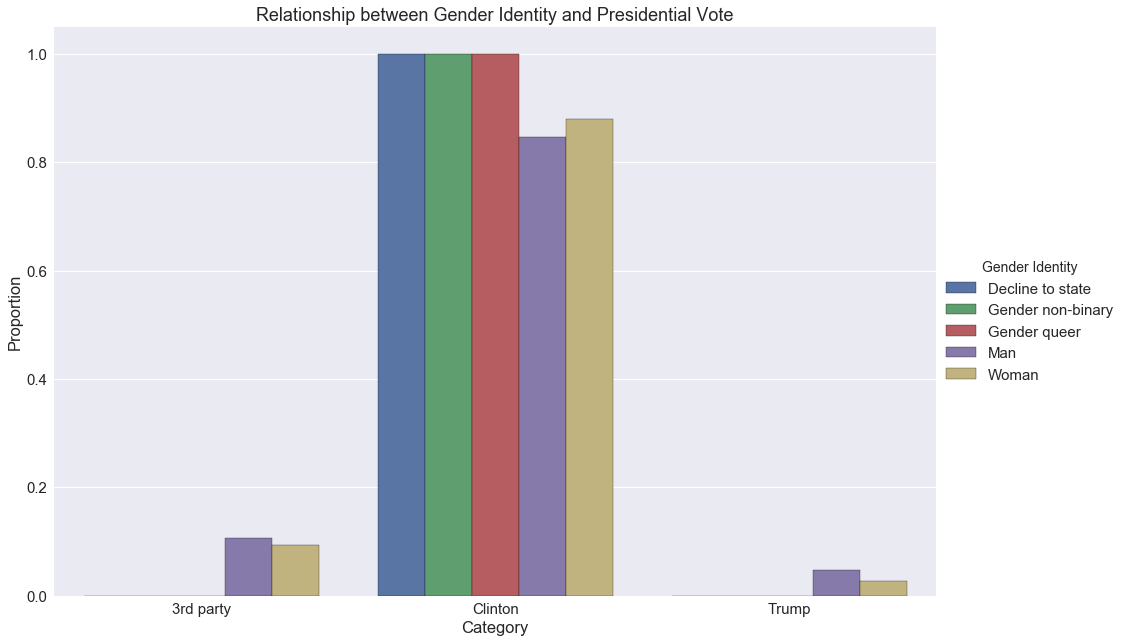

In [13]:
categorical_variable_relationship(data,
'Q7', 'Q17', 'Relationship between Gender Identity and Presidential Vote',
                                  'Gender Identity')

**Answer:** [Click on this cell and write your answer here]

**TASK**: Using your newly created **categorical_variable_relationship** function, plot a bar chart to find the relationship between Ethnic/Racial Identity **'Q8'** and Presidential vote **'Q17'**. Interpret the chart and write your findings below.

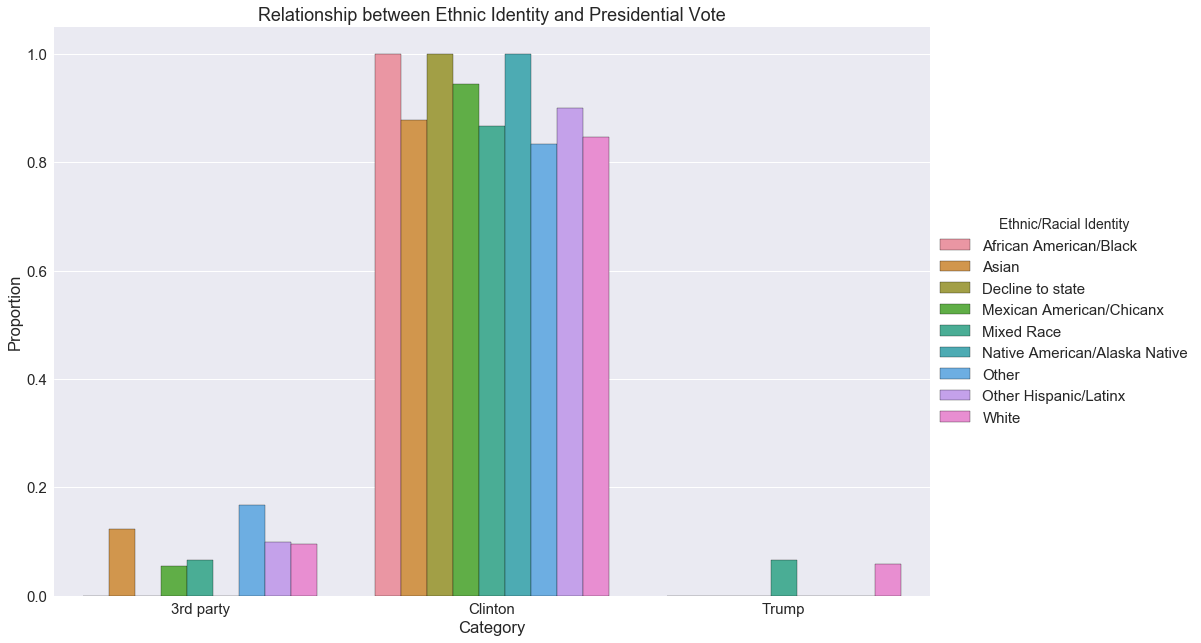

In [14]:
categorical_variable_relationship(data,
                                  'Q8', 'Q17', 'Relationship between Ethnic Identity and Presidential Vote',
                                  "Ethnic/Racial Identity")

**Answer:** [Click on this cell and write your answer here]

### Part II: Significance Tests for Categorical Variables [In Progress]

So far, we've created pivot tables between categorical variables and plotted bar charts to compare distributions. Based on these charts, we were able to come up with *qualitative differences* between variables. However, how do we know that these differences are not due to *random chance* alone? To answer this question we turn to **hypothesis testing** for categorical variables. 

**Exercise 2.1: Adding Row & Column Totals**

Before we can come to any conclusions, we must first do some leg work. Let's take a look at our basic pivot table first. 

In [15]:
pivoted_major_presidential_votes

Q17,Arts & Humanities,Business,Engineering/Computer Science,Life Sciences,Physical Sciences/Mathematics,Social Sciences
3rd party,6,2,4,5,1,5
Clinton,34,7,41,44,14,68
Trump,2,1,2,0,0,3


In [16]:
def add_row_totals(table):
    row_totals = np.array([])
    for i in np.arange(table.num_rows):
        all_counts = np.array(table.row(i)[1:])
        row_sums = sum(all_counts)
        row_totals = np.append(row_totals, row_sums)
    return table.with_column('Row Total', row_totals)
add_row_totals(pivoted_major_presidential_votes)

Q17,Arts & Humanities,Business,Engineering/Computer Science,Life Sciences,Physical Sciences/Mathematics,Social Sciences,Row Total
3rd party,6,2,4,5,1,5,23
Clinton,34,7,41,44,14,68,208
Trump,2,1,2,0,0,3,8


In [17]:
def add_column_totals(table):
    data = table.drop(0)
    col_sums = []
    col_sums.append('Column Total')
    for label in data.labels:
        total = np.sum(data.column(label))
        col_sums.append(total)
    return table.with_row(col_sums)

add_column_totals(pivoted_major_presidential_votes)

Q17,Arts & Humanities,Business,Engineering/Computer Science,Life Sciences,Physical Sciences/Mathematics,Social Sciences
3rd party,6,2,4,5,1,5
Clinton,34,7,41,44,14,68
Trump,2,1,2,0,0,3
Column Total,42,10,47,49,15,76


### Part III: Relationship between Demographic Factors and Ease of Voting

#### Exercise 3.1: Understanding the Data

Let's take a look at the column representing the difficulty/ease of voting. 

**TASK:** Use table function **.select** to display the relevant column. If there are many missing values, use the **drop_missing_rows** function to get a better look at the data.

In [18]:
drop_missing_rows(data.select('Q29_1'), 'Q29_1')

Q29_1
3
1
1
2
3
2
1
2
1
4


**Question:** What do you observed about the data? Are we working with numbers? How will this affect the way we go about analyzing the data?

*Hint:* Look back at the Data Table Legend for information. 

**Answer:** [Click on this cell and write your answer here]

#### Exercise 3.2: Plotting Ordinal Data

Since these are responses on a Likert scale, they cannot be manipulated and operated on like regular numerical data. For instance, it doesn't make sense to take the *average* of *Extremely Easy* and *Slighly Difficult*. At the end of the day, Likert scale responses are opinions, so they fundamentally are categorical variables. Thus, techniques that you learned before still apply. 

**TASK:** In the cell below, plot the relationship between **Major ('Q5')** and **Ease of Voter Registration ('Q29_1')**. Interpret the visualization. Do the same for **Gender Identity ('Q7')** and **Ethnic Identity ('Q8')**.

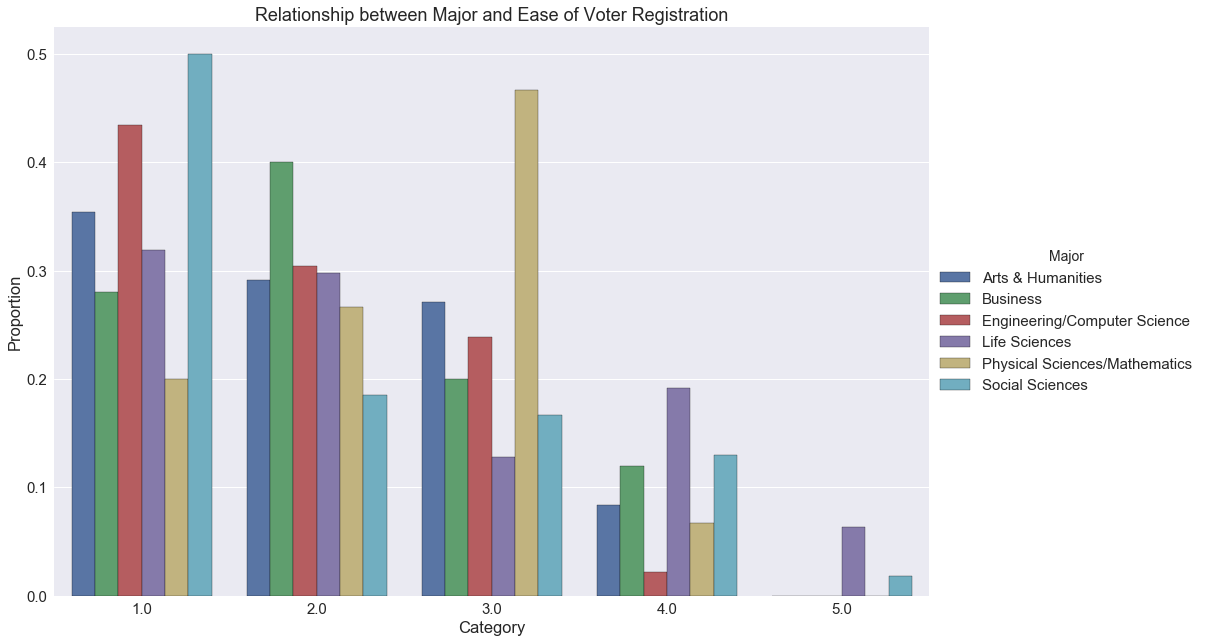

In [19]:
categorical_variable_relationship(data, 'Q5', 'Q29_1', 'Relationship between Major and Ease of Voter Registration', 'Major')

**Answer:** [Click on this cell and write your answer here.]

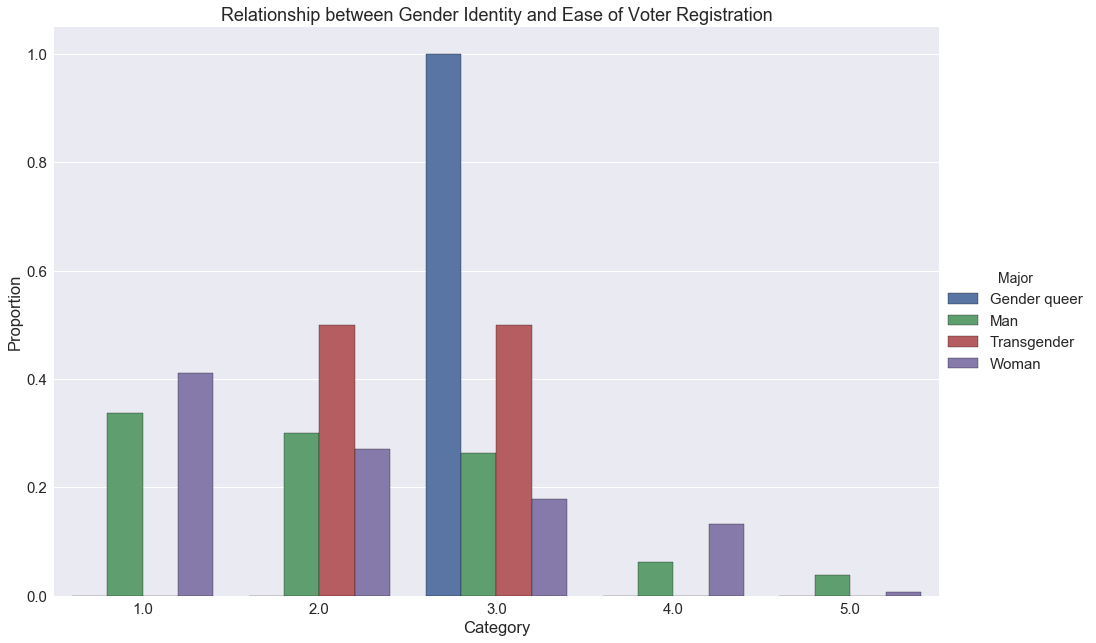

In [20]:
categorical_variable_relationship(data, 'Q7', 'Q29_1', 'Relationship between Gender Identity and Ease of Voter Registration', 'Major')

**Answer:** [Click on this cell and write your answer here.]

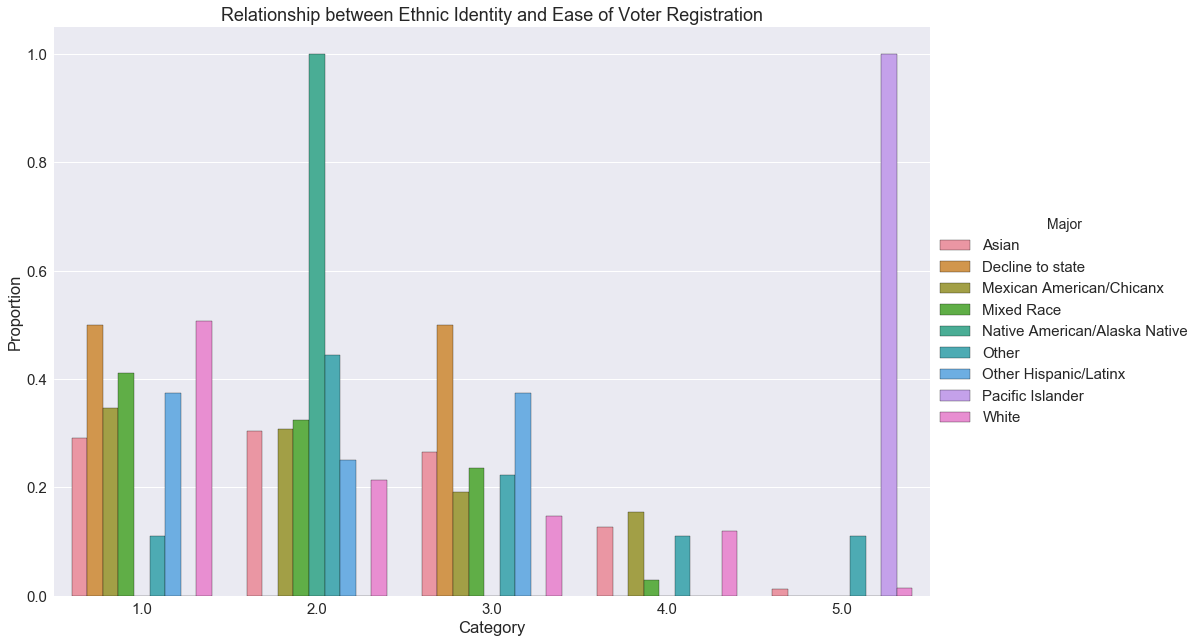

In [21]:
categorical_variable_relationship(data, 'Q8', 'Q29_1', 'Relationship between Ethnic Identity and Ease of Voter Registration', 'Major')

**Answer:** [Click on this cell and write your answer here.]

### Part III: Relationship between Political Ideology and Positions on Campus Political Climate

#### Exercise 3.1: Understanding the Data

Lastly, we'll look at the relationship between political ideology and campus political climate. 

**TASK:** As before, display the relevant columns of the data table with the **.select** function. Make sure to remove missing data in each column with **drop_missing_rows**

In [22]:
ideology_vs_climate = drop_missing_rows(drop_missing_rows(data.select(['Q41_23', 'Q40_1']), 'Q41_23'), 'Q40_1')
ideology_vs_climate

Q41_23,Q40_1
7,1
7,4
2,5
4,4
3,4
1,1
2,4
4,5
5,3
5,4


**Task:** Plot the relationship between political ideology and feelings about political discourse on campus. Write your observations below.

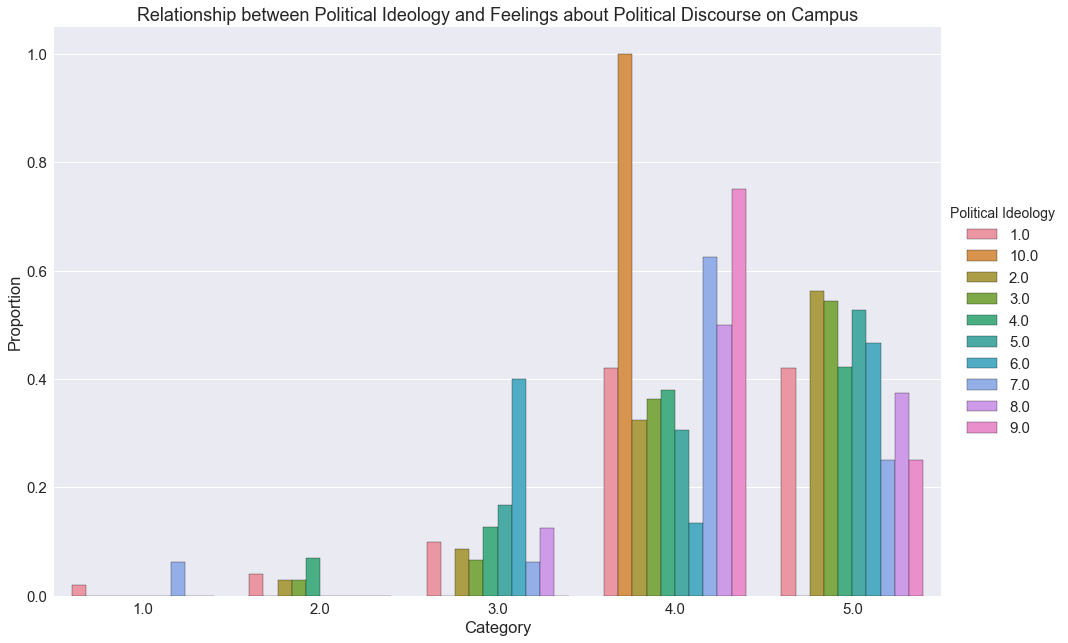

In [23]:
categorical_variable_relationship(ideology_vs_climate, 'Q41_23', 'Q40_1', 'Relationship between Political Ideology and Feelings about Political Discourse on Campus', 'Political Ideology')

**Answer:** [Click on this cell and write your response here]

### Part 4: Analyzing Text Responses [In Progress]

So far, we've been dealing with survey data in the form of multiple choice questions or rankings. However, sometimes in a survey, you want to ask responders to enter text or multple responses for their answer. One example of this is the column **'Q20'** which is about the responder's reaction to the result of the 2016 election.

#### Exercise 4.1: Word Clouds

To deal with data in the form of text, we can use word cloud. These data visualizations are commonly used when you want to display the most frequently occuring words in a piece of text. They work by counting the number of occurences of each word in a set of text, and then display each word proportionally to its frequency. Thus, more frequent words look bigger and vice versa. 

**TASK:** Create a wordcloud for the column **"Q20"** using the **create_wordcloud** function, which takes in a table name and a column name containing text data. Write your observations below. 

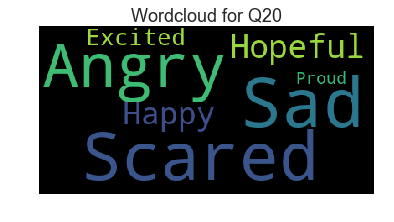

In [24]:
create_wordcloud(data, 'Q20')

**Answer**: [Click on this cell and write your answer here]